# PyCUDA: querying devices and simple kernels

This notebook is based on the book *Hands on GPU programming with Python and CUDA* by Brian Tuomanen (ISBN 978-1-78899-391-3).

## Querying device information

Import the CUDA driver.

In [2]:
import pycuda.driver as drv

Initialize the driver.

In [3]:
drv.init()

Query the number of available devices.

In [4]:
drv.Device.count()

1

For convenience, assign the device to a variable.

In [5]:
dev = drv.Device(0)

Get the name of the device.

In [6]:
dev.name()

'Tesla P100-SXM2-16GB'

Verify the CUDA compute capability of this device.

In [7]:
dev.compute_capability()

(6, 0)

Check the total memory of the device.

In [8]:
dev.total_memory()/1024**3

15.8992919921875

## Simple computations

Import and initialize the driver if not already done. Import `gpuarray` to get data into the device memory.

In [9]:
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray

Create a numpy array in the host memory.

In [10]:
host_data = np.array([1.1, 2.2, 3.3, 4.4], dtype=np.float32)

Transfer the array to device memory and perform a simple computation on it.

In [11]:
gpu_data = gpuarray.to_gpu(host_data)

In [12]:
gpu_data_new = 3.14*gpu_data

Transfer the array from device memory to host memory.

In [13]:
host_data_new = gpu_data_new.get()

In [14]:
host_data_new

array([ 3.4540002,  6.9080005, 10.362    , 13.816001 ], dtype=float32)

Let's measure performance. Create a host array of 10 million elements.

In [15]:
host_data = np.random.uniform(size=10_000_000).astype(np.float32)

Time a simple computation, including transferring data to and from device memory.

In [16]:
%%timeit -n 1 -r 1
gpu_data = gpuarray.to_gpu(host_data)
gpu_data_new = gpu_data*np.float32(2.0)
host_data_new = gpu_data_new.get()

25.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Time the duration of the actual computation, so without data transfer overhead.

In [17]:
gpu_data = gpuarray.to_gpu(host_data)

In [18]:
%%timeit -n 1 -r 1
gpu_data_new = gpu_data*np.float32(2.0)

540 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
%timeit np.float32(2.0)*host_data

2.36 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Although it would in theory be possible to perform computation using this style of programming, this would be very inefficient.  Computations on a GPGPU are typically coded using kernel functions.

### Elementwise kernels

Required imports.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.elementwise import ElementwiseKernel

We will compute the Mandelbrot set.  First, initialize the initial values for $z$.

In [21]:
min_val, max_val, nr_points = -1.8, 1.8, 2**14
lattice = (np.linspace(min_val, max_val, nr_points, dtype=np.complex64).reshape((1, -1)) +
           np.complex64(1.0j)*np.linspace(min_val, max_val, nr_points, dtype=np.complex64).reshape((-1, 1)))

Transfer the data to the GPU.

In [22]:
lattice_gpu = gpuarray.to_gpu(lattice)

Create an empty array of the same shape on the GPU.

In [23]:
graph_gpu = gpuarray.empty(lattice.shape, dtype=np.float32)

Define the CUDA elementwise kernel.
  * The first argument represents the parameters of the kernel function.  Note that 2D numpy arrays will be passed as 1D C arrays to the kernel function.
  * The second argument is the source code for the kernel function.  Note that an index `i` for the arrays passed as arguments is automatically generated.
  * The third argument is the name of the kernel function.
  
We can use the C types, exept for complex numbers, which should be typed as `pycuda::complex<float>` for single precision floating point numbers.

`int` on the device is 32-bit, so the Python 3 integer should be converted into a numpy 32-bit integer.

In [24]:
kernel = ElementwiseKernel(
    'pycuda::complex<float> *lattice, float *graph, int max_iters, float upper_bound',
    '''
    graph[i] = 1.0f;
    pycuda::complex<float> c = lattice[i];
    pycuda::complex<float> z(0.0f, 0.0f);
    for (int j = 0; j < max_iters; ++j) {
        z = z*z + c;
        if (abs(z) > upper_bound) {
            graph[i] = 0.0f;
            break;
        }
    }
    ''',
    'madelbrot_kernel'
)

Launch the kernel function, retrieve and display the result.

In [25]:
kernel(lattice_gpu, graph_gpu, np.int32(255), np.float32(2.0))

In [26]:
graph = graph_gpu.get()

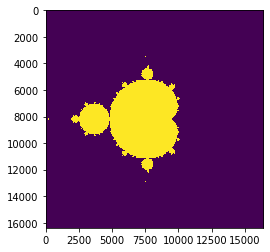

In [27]:
plt.imshow(graph);

### Scan kernels

Required imports.

In [28]:
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.scan  import InclusiveScanKernel

We perform a scan on an array, computing the running sum of its elements.

In [29]:
host_data = np.arange(1, 30, 3, dtype=np.int32)
host_data

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28], dtype=int32)

In [30]:
gpu_data = gpuarray.to_gpu(host_data)

Define and run the kernel.

In [31]:
kernel = InclusiveScanKernel(np.int32, "a + b")

In [32]:
kernel(gpu_data)

array([  1,   5,  12,  22,  35,  51,  70,  92, 117, 145], dtype=int32)

Note that the computation has been done in place, the result is just returned forconvenience.

In [33]:
gpu_data.get()

array([  1,   5,  12,  22,  35,  51,  70,  92, 117, 145], dtype=int32)

### Reduction kernels

Required imports.

In [34]:
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.reduction import ReductionKernel

In [35]:
host_data = np.random.normal(size=100_000_000).astype(np.float32)

In [36]:
gpu_data = gpuarray.to_gpu(host_data)

We define a kernel that computes the maximum of the array.  This can be done by an elementwise reduction with the first array element as the neutral element.

In [37]:
max_kernel = ReductionKernel(np.float32,
                             neutral=str(host_data[0]),
                             reduce_expr='a > b ? a : b',
                             arguments='float *in')

In [38]:
max_kernel(gpu_data)

array(5.7034426, dtype=float32)

The result is identical when computed on the CPU using numpy.

In [39]:
host_data.max()

5.7034426

A similar kernel can be defined for the minimum of an array.

In [40]:
min_kernel = ReductionKernel(np.float32,
                             neutral='0.0',
                             reduce_expr='a > b ? b : a',
                             arguments='float *in')

In [41]:
min_kernel(gpu_data)

array(-5.556572, dtype=float32)

In [42]:
host_data.min()

-5.556572

Note that the result as returned as a numpy array with a single element.

The `ReductionKernel` is in fact more powerful, it can be used to implement a map-reduce operation.  We can implement the scalar product of two vectors easily.

In [43]:
dot_kernel = ReductionKernel(np.float32,
                             neutral='0.0',
                             reduce_expr='a + b',
                             map_expr='v1[i]*v2[i]',
                             arguments='float *v1, float *v2')

Create two vectors on the host system, and transfer to the device memory.

In [44]:
host_v1 = np.random.uniform(size=10_000_000).astype(np.float32)
host_v2 = np.random.uniform(size=10_000_000).astype(np.float32)

In [45]:
gpu_v1 = gpuarray.to_gpu(host_v1)
gpu_v2 = gpuarray.to_gpu(host_v2)

In [46]:
dot_kernel(gpu_v1, gpu_v2)

array(2499344.8, dtype=float32)

The result is nearly the same on the CPU, except for the least signicant digit due to rounding differences consistent with single precision arithmetic.

In [47]:
host_v1@host_v2

2499345.0